# Lysozyme test case

In the following example we will be using TrIPP to determine the p*K*<sub>a</sub> values of the hen egg-white lysozyme (HEWL; PDB ID: 1AKI). Two replicas are included in this tutorial. The files can be found in the data folder and contain a PDB file of the minimised structure of lysozyme and two XTC files of the 300 ns trajectory sampled every 100 ps. Water have been removed in the trajectory. All simulations were run with standard protonation states at pH 7.0.

First, let us import everything we need for the following notebook.

In [1]:
from tripp import Trajectory
from tripp.analysis import calculate_difference_to_model
from tripp.analysis import PCProjectionScreening  
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tripp._model_pka_values_ import model_pka_values
from tripp import Visualization  # PyMOL application required, user needs to specify the path to PyMOL executable
from tripp import Clustering 

And also all the variables needed for the following analysis.

In [2]:
topology_file = f'data/1AKI_minstr.pdb'
trajectory_files = ['data/1AKI_md1_300ns.xtc','data/1AKI_md2_300ns.xtc']
output_directories = ['output/MD1','output/MD2']
output_prefix = ['MD1','MD2']

trajectory_dict = {'MD1' : 'data/1AKI_md1_300ns.xtc',
                   'MD2' : 'data/1AKI_md2_300ns.xtc'}
pka_files = ['output/MD1/MD1_pka.csv', 'output/MD2/MD2_pka.csv']
output_directory = 'output'

# Make sure you specify where your pymol installation is if you want to run Visualization class in the notebook
pymol_path = '/Applications/PyMOL.app/Contents/MacOS/MacPyMOL'

# Pseudomutations in TrIPP section, can comment out if you do not run this section.
mutations = [44, 46, 59, 114]
mutation_output_directories = [['output/MD1_44', 'output/MD1_46', 'output/MD1_59', 'output/MD1_114'],
                               ['output/MD2_44', 'output/MD2_46', 'output/MD2_59', 'output/MD2_114']]
mutation_pKa_files = [['output/MD1/MD1_pka.csv', 'output/MD1_44/MD1_44_pka.csv','output/MD1_46/MD1_46_pka.csv','output/MD1_59/MD1_59_pka.csv','output/MD1_114/MD1_114_pka.csv'],
                      ['output/MD2/MD2_pka.csv', 'output/MD2_44/MD2_44_pka.csv','output/MD2_46/MD2_46_pka.csv','output/MD2_59/MD2_59_pka.csv','output/MD2_114/MD2_114_pka.csv']]
mutation_names = ['Wild type', 'ASN44ALA', 'ASN46ALA', 'ASN59ALA', 'ARG114ALA']

# Automated screening of custom PC projections section, can comment out if you do not run this section.
pKaCSV = 'output/MD1/MD1_pka.csv'
ProjectionCSV = 'data/1AKI_md1_pc1.csv'
correlation_file = 'output/MD1_pc1_projection_pKa_PearsonCorrelation.csv'


In the following sections, you will learn how to:
1. Predict p*K*<sub>a</sub> of ionisable residues and analyse the distribution of the p*K*<sub>a</sub> values for the entire trajectory.
2. Visualize the mean p*K*<sub>a</sub> and mean difference to the model p*K*<sub>a</sub> values. (PyMOL installation required)
3. Clustering the p*K*<sub>a</sub> values of selected residues and retrieve cluster representatives.
4. Mutating selected residue(s) in the exisiting trajectory and understand the contributions of the selected residue(s) to another residue of interest.
5. Screen projections along a given principal componenet to identify correlation with all ionisable residues in the system.

# 1. Trajectory p*K*<sub>a</sub> prediction

One of the function provided by TrIPP is to calculate the p*K*<sub>a</sub> values for the entire trajectory using PROPKA3.4. To optimize the speed, TrIPP slices the trajectory into parts and each part is processed with different cores in your machine. The p*K*<sub>a</sub> values and buriedness (if specified) of each ionizable residues will be extracted into separate CSV files.

We would like to highlight that PROPKA has several specific requirements for the topology, we are aware of the following:

1. It only recognizes specific resname for 20 amino acids.
2. The two C-terminal oxygens atom name should be named O and OXT.
3. The record type of non protein molecules (ie: ligand) should be named 'HETATM'.

TrIPP has a hard-coded dictionary (tripp.\_correction_dictionary_.py) that converts MDAnalysis recognizable resname to the corresponding resname compatible with PROPKA. Similarly, we have included the conversion of C-terminal oxygens atom names for GROMOS, AMBER, CHARMM forcefield. Molecules that is not recognized by MDAnalysis (not protein) could still be a residue or non protein molecules. Thus, we have also implemented a check for this so that user will be warned to modify it accordingly.

We will showcase the p*K*<sub>a</sub> prediction of two HEWL MD trajectories, which in this case no ligand is in complex with the protein.

In [3]:
# Cell 1.1
for idx in range(len(trajectory_files)):
    print(f'Processing {trajectory_files[idx]}')
    TrIPP_Traj = Trajectory(topology_file=topology_file,
                            trajectory_file=trajectory_files[idx],
                            output_directory = output_directories[idx],
                            output_prefix = output_prefix[idx],
                            hetatm_resid=None,  # If your topology contains non protein molecules, you can set the record type to HETATM through this argument by providing the resid.
                            custom_terminal_oxygens=None,  # If the atom name of your terminal oxygen is not O or OXT, you can provide a list to correct them. ie: ['OC1', 'OC2']
                            custom_resname_correction=None,  # If the resname of your topology cannot be recognized by MDAnalysis (not protein) and it is not a non protein molecules, you can add a dictionary to correct them. ie: {'XXX':'ASP'}
                            cpu_core_number=-1) # Setting the argument cpu_number to -1 allows for the use of all available CPUs 
    
    TrIPP_Traj.run(extract_buriedness_data=True,  # If set to False, only pKa data will be saved as CSV, else both pKa and buriedness data will be saved
                   chain='A',  # Default is chain = 'A', if system does not contain chain ID, it will add 'A' to the whole system.
                   mutation=None,  # For now no pseudomutation will be performed.
                   disulphide_bond_detection=True,  # If set to True, cysteines that form disulphide bond will not be saved in the CSV file.
                   optargs=[])  # optargs for PROPKA.run.single()
    print('---------------------------------------------------------------------------------')

Processing data/1AKI_md1_300ns.xtc
---------------------------------------------------------------------------------
Processing data/1AKI_md2_300ns.xtc


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------


Note that you might see a warning message from PROPKA about "Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure". Our understanding to this is that PROPKA has a pre-defined number of interactions for different groups (https://propka.readthedocs.io/en/latest/_modules/propka/group.html). The conformation of the residue would change throughout the trajectory. Hence, the number of interactions is not definite.

Two new directories (MD1 and MD2) are created in the output directory since we have two trajectories. Each contains a MD?_pka.csv and MD?_buriedness.csv file (each row corresponds to a timestep and each column to a residue). All parameters that are chosen for the calculation and some statstics (Mean,Median,Standard Deviation) of the p*K*</sub>a</sub> of each ionisable residues are written in the MD?.log file.

The distribution of the p*K*<sub>a</sub> values can be visualized with the following code. This allows us to determine, which residues are more likely to change protonation state and diverge the most from model values. Note N+ and C- correspond to the N-terminal and C-terminal residue, respectively.

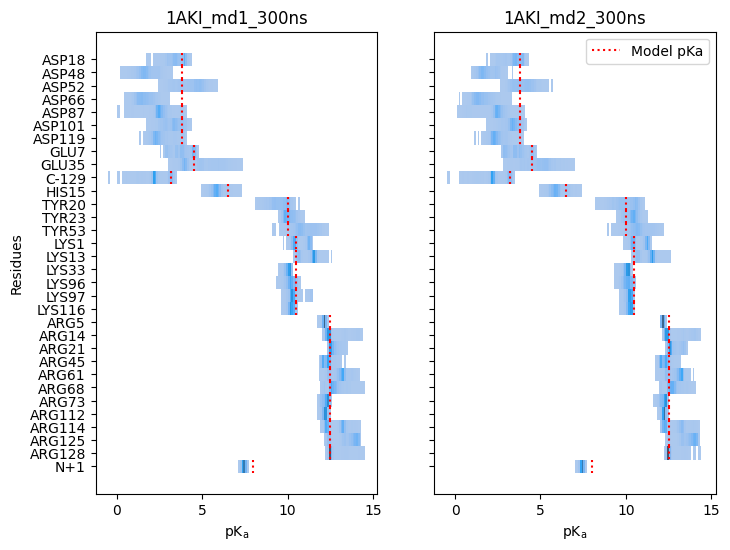

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharex=True, sharey=True) 

#Plot histogram showing the pKa values
for idx in range(len(trajectory_files)):
    df_md = pd.read_csv(f'{output_directories[idx]}/{output_prefix[idx]}_pka.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value') 
    sns.histplot(data=df_melt, x='pKa value', y='Residues', ax=ax[idx], binwidth=0.1)
    ax[idx].set(xlabel=r'pK$_{\rm a}$')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
    #Adding model pKa value to each row
    for ytick, residue in enumerate([i[:3] for i in df_melt['Residues'].unique()]):
        if 'N+' in residue:
            ax[idx].vlines(model_pka_values['NTR'],ytick-0.5,ytick+0.5,colors='red',linestyles='dotted')
        elif 'C-' in residue:
            ax[idx].vlines(model_pka_values['CTR'],ytick-0.5,ytick+0.5,colors='red',linestyles='dotted')
        else:
            ax[idx].vlines(model_pka_values[residue],ytick-0.5,ytick+0.5,colors='red',linestyles='dotted')
ax[1].legend(['Model pKa'])
plt.show()

It is often the case that the deviation of the p*K*<sub>a</sub> value of a residue in a protein from its model value in solution is important. It is affected by the interactions with the local environments (electrostatic, hydrogen bonding, apolar etc). TrIPP offers a function to determine the deviation for every residue compared to its model value during the trajectory. 

We can use `calculate_difference_to_model` function imported earlier to calculate the difference to the model value for each residue, which is saved as a CSV file.

In [5]:
for idx in range(len(trajectory_files)):
    calculate_difference_to_model(output_directory = output_directories[idx],
                                  output_prefix = output_prefix[idx]) 

The distribution can be viewed once again with the following code.

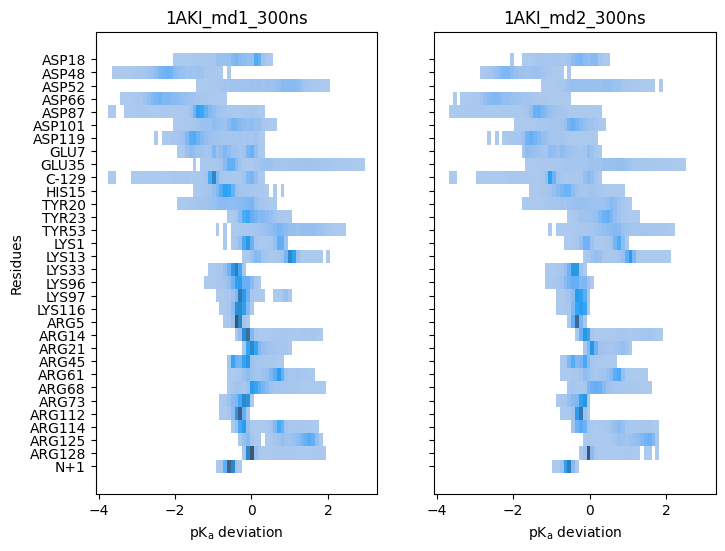

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8, 6), sharex=True, sharey=True) 

#Plot histogram showing the deviation from the model pKa values 
for idx in range(len(trajectory_files)):
    df_md = pd.read_csv(f'{output_directories[idx]}/{output_prefix[idx]}_difference_to_model.csv') 
    df_melt = df_md.melt(id_vars='Time [ps]', var_name='Residues', value_name='pKa value deviation') 
    sns.histplot(data=df_melt, x='pKa value deviation', y='Residues', ax=ax[idx], binwidth=0.1)
    ax[idx].set(xlabel=r'pK$_{\rm a}$ deviation')
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
plt.show()

The acidic residues ASP52 and GLU35 are of particular interest since they show an upshift of their p*K*<sub>a</sub> values. The model p*K*<sub>a</sub> values for aspartate and glutamate residues are 3.8 and 4.5, respectively. An increase of their p*K*<sub>a</sub> due to the changes in the local environement would change their protonation state. These two residues are involved in the catalytic mechanism of a glycosidic bond in the HEWL.

# 2. Visualizing with PyMOL

The `Visualization` class in TrIPP allows p*K*<sub>a</sub> values to be mapped onto a topology file provided by the user. This is a convenient feature when the user would like to visualize the p*K*<sub>a</sub> values (mean or mean difference to model) with the protein or rendering figures with PyMOL.

We will use both p*K*<sub>a</sub> CSV files from MD1 and MD2 to generate a PyMOL session with the mean p*K*<sub>a</sub> values mapped onto the initial minimised structure of HEWL. 

In [7]:
# Cell 2.1
TrIPP_Vis = Visualization(topology_file=topology_file, 
                          pka_file=pka_files) # Can be str or list of str, with the path to the pKa file(s)

TrIPP_Vis.gen_pse(pymol_path=pymol_path,
                  output_directory=output_directory,
                  output_prefix='All_md_pka',
                  chain = 'A',
                  coloring_method='mean',  # Output PyMOL session with the mean pKa 
                  lower_limit=0,  # Minimum of the colour bar
                  upper_limit=14,  # Maximum of the colour bar
                  color_palette='red_white_blue')  #

 PyMOL(TM) 3.0.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.


[<img src="data/Mean_pka.png" width="700"/>](data/Mean_pka.png)

One can also generates a PyMOL session for the difference of the mean p*K*<sub>a</sub> to the model p*K*<sub>a</sub> value.

In [8]:
# Cell 2.2
TrIPP_Vis = Visualization(topology_file=topology_file, 
                          pka_file=pka_files) 

TrIPP_Vis.gen_pse(pymol_path=pymol_path,
                  output_directory=output_directory,
                  output_prefix='All_md_pka',
                  chain='A',
                  coloring_method='difference_to_model_value',  # Output PyMOL session with the difference between the mean to the model pKa 
                  lower_limit=-3,  # Minimum of the colour bar
                  upper_limit=2,  # Maximum of the colour bar
                  color_palette='red_white_blue') 

 PyMOL(TM) 3.0.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.


[<img src="data/Difference_to_model_pka.png" width="700"/>](data/Difference_to_model_pka.png)

# 3. Clustering with p*K*<sub>a</sub> values

With the data generated by PROPKA, one can inspect the relationship between any residues through clustering. As an example, we will determine the relationship between ASP52 and GLU35. First, let us plot the p*K*<sub>a</sub> values for these two residues in MD1 and MD2.

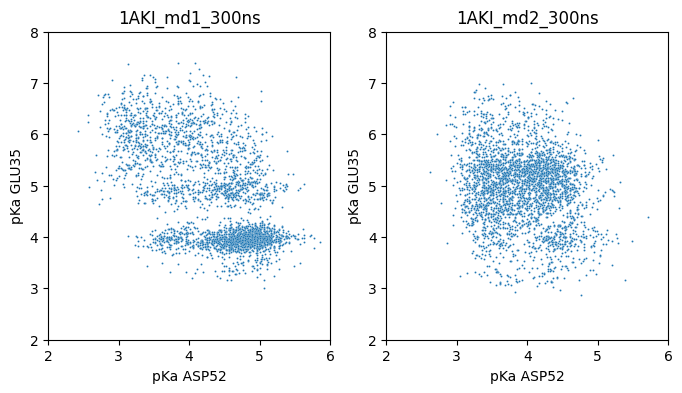

In [9]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

for idx in range(len(trajectory_files)):
    df_md = pd.read_csv(pka_files[idx]) 
    sns.scatterplot(data=df_md, x='ASP52', y='GLU35', ax=ax[idx], s=2) 
    ax[idx].set_xlim(2,6) 
    ax[idx].set_ylim(2,8) 
    ax[idx].set_xlabel('pKa ASP52') 
    ax[idx].set_ylabel('pKa GLU35') 
    ax[idx].set_title(f"{trajectory_files[idx].split('/')[-1].split('.')[0]}")
plt.show()

The scatterplots of the p*K*<sub>a</sub> values of GLU35 and ASP52 show two distinct populations of points, particularly in MD1 and less so in MD2. One can utilise clustering methods (GROMOS/KMedoids/DBSCAN) provided in the TrIPP to cluster the data.

We will cluster both trajectories with KMedoids to identify cluster representative structures. The two p*K*<sub>a</sub> files are combined together internally and create a clustering matrix based on z score between the features selected (buriedness/distances between charged center).

In [10]:
# Cell 3.1
TrIPP_Clust = Clustering(topology_file=topology_file, 
                         trajectory_file=trajectory_dict,  # Dictionary where the key is the name of the trajectory, and the value is the path to the trajectory
                         pka_file=pka_files,  # List of paths to pKa files
                         buriedness_file=None,
                         residues=[35, 52],  # List of int that contain the residues you would like to study
                         output_directory=output_directory,
                         output_prefix='All_md', 
                         include_distances=False,  # If set to true, zscore of pKa values and the distance between charged center will be used to build the clustering matrix
                         include_buriedness=False,  # If set to true, zscore of pKa values and the buriedness will be used to build the clustering matrix
                         dimensionality_reduction=False)  # If set to true, principle component analysis will be performed on the clustering matrix. Prinicple component up to 90% varaince will be retained.

TrIPP_Clust.kmedoids(automatic=True,  # automatic searching for the optimal hyperparameters of kmedoids (evaluated by Silhouette score).
                     max_clusters=20)  # the maximum number of clusters for automatic searching.

Clustering with 2 clusters produces an average silhouette score of 0.4647.
Clustering with 3 clusters produces an average silhouette score of 0.3871.
Clustering with 4 clusters produces an average silhouette score of 0.4348.
Clustering with 5 clusters produces an average silhouette score of 0.4184.
Clustering with 6 clusters produces an average silhouette score of 0.4045.
Clustering with 7 clusters produces an average silhouette score of 0.3441.
Clustering with 8 clusters produces an average silhouette score of 0.3832.
Clustering with 9 clusters produces an average silhouette score of 0.3851.
Clustering with 10 clusters produces an average silhouette score of 0.3511.
Clustering with 11 clusters produces an average silhouette score of 0.3278.
Clustering with 12 clusters produces an average silhouette score of 0.3251.
Clustering with 13 clusters produces an average silhouette score of 0.3267.
Clustering with 14 clusters produces an average silhouette score of 0.3467.
Clustering with 15 c

The clustering produces a log file containing the clustering details (output/All_md_KMedoids.log), a PDB file for each cluster containing the cluster representative structure (All_md_KMedoids_C0.pdb and All_md_KMedoids_C1.pdb), and a CSV file containing the p*K*<sub>a</sub> values with its respective cluster label at different time (All_md_KMedoids_cluster.csv).

We can now plot the clustering results to determine the quality of the clustering.  

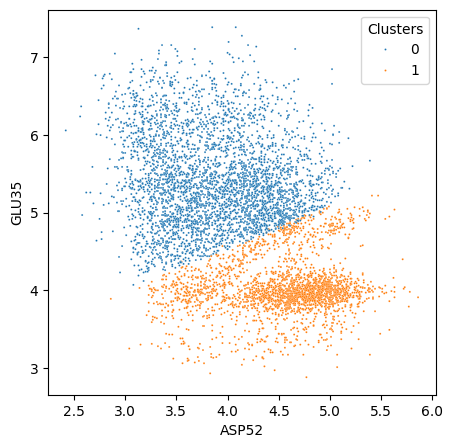

In [63]:
fig = plt.subplots(figsize=(5,5)) 

df_cluster = pd.read_csv(f'{output_directory}/All_md_KMedoids_cluster.csv') 
sns.scatterplot(data=df_cluster, x='ASP52', y='GLU35', s=2, hue='Clusters', palette='tab10')
plt.show()

In [31]:
with open(f'{output_directory}/All_md_KMedoids.log','r') as f:
    for line in f.readlines():
        if line.startswith('Centroid trajectory'):
            print(line.strip().split()[-1])

MD2
MD1


In [33]:
df_cluster[df_cluster['Time [ps]'] == 20200.0].iloc[1]['ASP52']
df_cluster[df_cluster['Time [ps]'] == 20200.0].iloc[1]['GLU35']
df_cluster[df_cluster['Time [ps]'] == 46000.0].iloc[0]['ASP52']
df_cluster[df_cluster['Time [ps]'] == 46000.0].iloc[0]['GLU35']

5.31

We can inspect the difference between the two cluster representatives (centroids).

In cluster 0, ASN44 hydrogen bond with ASP52, which lowers the p*K*<sub>a</sub> of the aspartate. GLU35 is not interacting with ARG114 which increases its p*K*<sub>a</sub> value. 

In cluster 1, ASN44 flips away from ASP52, which interacts with the backbone of GLU35. This in turn increases the p*K*<sub>a</sub> of the aspartate. In contrast, GLU35 hydrogen bond with ARG114, which decreases the p*K*<sub>a</sub> of the glutamate. 

One could try to include distance/buriedness, or even perform dimenstionality reduction on the clustering matrix prior clustering by setting the hyperparameters to `True`.

[<img src="data/Kmedoids_C0.png" width="700"/>](data/Kmedoids_C0.png)


[<img src="data/Kmedoids_C1.png" width="700"/>](data/Kmedoids_C1.png)

# 4. _Pseudomutations_ in TrIPP 

TrIPP offers a built-in way to understand the contribution of interactions to the p*K*<sub>a</sub> of a residue. The way TrIPP does this is by running the p*K*<sub>a</sub> iterator of the `Trajectory` class and setting the `mutation` argument to the selected residues (ionisable residue near the residue of interest). This leads to TrIPP running the p*K*<sub>a</sub> calculations on the trajectory, however, with the selected residue being mutated to alanine. This does not affect the conformation of the trajectory in any way since no new MD simulations are run. By artificially removing the side chain functional group, one can determine the contribution of the selected residues to the p*K*<sub>a</sub> of another interacting residue throughout the original simulation.

In the following example, we will run a total of four _pseudomutations_ to check the contribution of: 
- ARG114 to GLU35
- ASN44, ASN46, and ASN59 to ASP52

In [12]:
# Cell 4.1
for idx in range(len(trajectory_files)):
    for mtype_idx, mutation in enumerate(mutations):
        mutation_output_prefix = f'{output_prefix[idx]}_{mutation}'
        print(f'Processing pseudomutation resid {mutation} in {trajectory_files[idx]}.')
        
        TrIPP_Traj = Trajectory(trajectory_file=trajectory_files[idx], 
                                topology_file=topology_file,
                                output_directory = mutation_output_directories[idx][mtype_idx],
                                output_prefix = mutation_output_prefix,
                                cpu_core_number=-1) 
        
        TrIPP_Traj.run(extract_buriedness_data=False,
                        chain='A',
                        mutation=mutation,  # This can be a single or double mutation. In the case of double mutation, a list of int can be provided.
                        disulphide_bond_detection=True,
                        optargs=[])
        print('---------------------------------------------------------------------------------')

Processing pseudomutation resid 44 in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation resid 46 in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation resid 59 in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation resid 114 in data/1AKI_md1_300ns.xtc.
---------------------------------------------------------------------------------
Processing pseudomutation resid 44 in data/1AKI_md2_300ns.xtc.


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------
Processing pseudomutation resid 46 in data/1AKI_md2_300ns.xtc.


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------
Processing pseudomutation resid 59 in data/1AKI_md2_300ns.xtc.


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------
Processing pseudomutation resid 114 in data/1AKI_md2_300ns.xtc.


Missing atoms or failed protonation for ASN  27 A (AMD) -- please check the structure
Group (AMD) for   415-  CG    27-ASN (A) [  34.720   45.140   38.560] C
Expected 3 interaction atoms for acids, found:
               417- ND2    27-ASN (A) [  35.230   44.950   39.650] N
                 0- HD2    27-ASN (A) [  35.877   44.950   40.426] H
Expected 1 interaction atoms for bases, found:
               416- OD1    27-ASN (A) [  33.630   44.640   38.510] O
Missing atoms or failed protonation for ASN 106 A (AMD) -- please check the structure
Group (AMD) for  1572-  CG   106-ASN (A) [  25.120   50.670   38.470] C
Expected 3 interaction atoms for acids, found:
              1574- ND2   106-ASN (A) [  24.060   51.190   38.060] N
                 0- HD2   106-ASN (A) [  23.373   51.848   37.721] H
Expected 1 interaction atoms for bases, found:
              1573- OD1   106-ASN (A) [  24.970   49.530   38.690] O


---------------------------------------------------------------------------------


We can now plot a barplot to investigate the distribution of the p*K*<sub>a</sub> values of ASP52 and GLU35 with different _pseudomutations_ performed earlier to determine their contributions. 

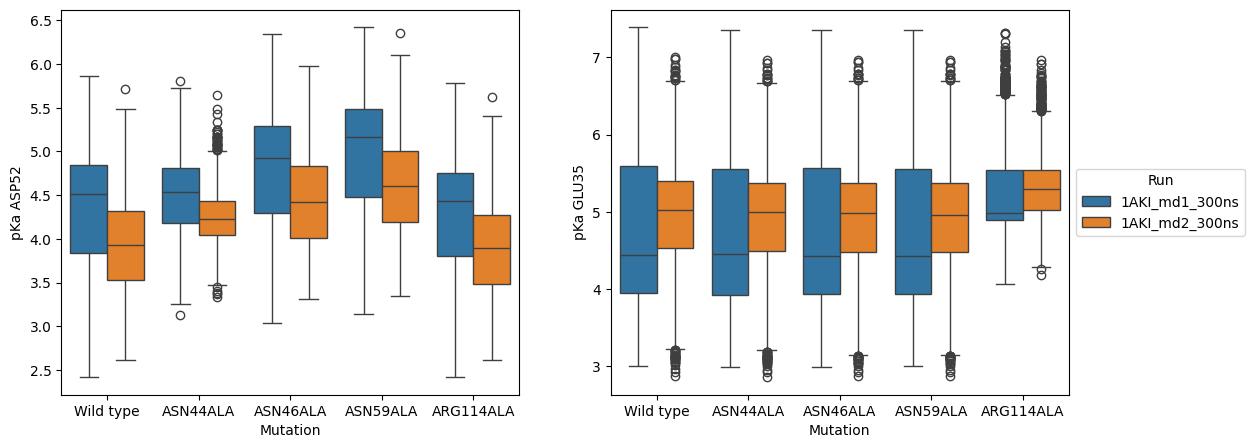

In [13]:
combined_df = []
for idx in range(len(trajectory_files)):
    for mtype_idx, mutation_name in enumerate(mutation_names):
        df = pd.read_csv(mutation_pKa_files[idx][mtype_idx])
        df = df[['Time [ps]', 'ASP52', 'GLU35']]
        df['Run'] = f"{trajectory_files[idx].split('/')[-1].split('.')[0]}"
        df['Mutation'] = mutation_name
        combined_df.append(df)
combined_df = pd.concat(combined_df)

fig, ax = plt.subplots(1,2, figsize=(13,5)) 
for index, residue in enumerate(['ASP52', 'GLU35']): 
    sns.boxplot(data=combined_df, x='Mutation', y=residue, hue='Run', ax=ax[index]) 
    sns.move_legend(ax[index], "center right", bbox_to_anchor=(1.4,0.5))
    ax[index].set_ylabel(f'pKa {residue}')
ax[0].legend([],[], frameon=False)
plt.show()

From the boxplot above, we can learn that _pseudomutation_ performed on ASN44, ASN46, and ASN59 changes the p*K*<sub>a</sub> distribution of ASP52. This makes sense because all ASN form hydrogen bond with ASP52 in the original trajectory. Note that ASN44 has a slightly different trend than the other two ASN when mutated. This is because ASN44 flipped away from ASP52 in some time during the trajectory which forms no interaction with ASP52. In contrast, ARG114 is not interacting with ASP52 but with GLU35 occassionally. Hence, we can see the change in p*K*<sub>a</sub> distribution of GLU35 when mutating ARG114 only.

# 5. Automated screening of custom PC projections

To understand the dynamics of the system, one can perform dimensionality reduction, such as principal component (PC) analysis, on the trajectory. The motion of the protein described by principal components could be related to the p*K*<sub>a</sub> values. To facilitate this analysis, we have implemented a function to automatcally screen the correlation between the projections along a given PC and the p*K*<sub>a</sub> of each ionizable residue. We acknowledge that the choice of featurization and dimensionality reduction methods depends on the user's preferences. Therefore, this analysis requires the user to provide the time evolution of the projections as a prerequisite.

The following code generates a CSV file that contains a column of each ionizable residue, their correlation coefficient with the projections along a given PC, and the associated p-value.

In [14]:
# Cell 5.1
PCProjectionScreening(output_directory=output_directory,
                      output_prefix='MD1_pc1_projection_pKa_PearsonCorrelation',
                      pka_file=pKaCSV,  # Path to the pKa CSV produced by Trajectory.run
                      projection_file=ProjectionCSV,  # Path to the time evolution of projection CSV file. Note specific format needed, please see example format in data/1AKI_md1_pc1.csv
                      method='Pearson')  # Correlation method, can be 'Pearson' or 'Spearman'

The correlation value can then be mapped to the structure using our `Visualization` class by providing the `correlation_file` generated earlier. You can also set `correlation_threshold` to show only residues above/below a given threshold for clarity.

In [15]:
# Cell 5.2
Corr_Vis = Visualization(topology_file=topology_file,
                         pka_file=pKaCSV,  # Path to the pKa file
                         correlation_file=correlation_file)  # Path to the correlation file 

Corr_Vis.gen_pse(pymol_path=pymol_path, 
                 output_directory=output_directory,
                 output_prefix='MD1_pc1_projection_pKa_PearsonCorrelation',
                 coloring_method='correlation',  # Set to correlation when you would like to color the system with correlation coefficient
                 lower_limit=-1,  # Minimum of the colour bar
                 upper_limit=1,  # Maximum of the colour bar
                 correlation_threshold=0.5,  # Show only residues with absolute correlation coefficient above this in PyMOL session
                 color_palette='red_white_blue')

 PyMOL(TM) 3.0.1 - Incentive Product
 Copyright (C) Schrodinger, LLC
 
 This Executable Build integrates and extends Open-Source PyMOL.
 Detected 12 CPU cores.  Enabled multithreaded rendering.


[<img src="data/PC_projection_correlation.png" width="700"/>](data/PC_projection_correlation.png)

The figure above indicates a strong correlation between ASP52, GLU35, ARG114, and the projections of MD1 in the first PC. This suggests that the motion described by the first PC largely influences the p*K*<sub>a</sub> values of these three residues.